# Research Actions

This document is research of semantic similarity between including actions sentences from different documents. 

In [27]:
# import used modules
import os
import numpy as np
import time
import pickle
from scipy.linalg import block_diag

In [28]:
# import a model and a module for semantic analys
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('../model.bin', binary=True) 
model.init_sims(replace=True)

/home/ased/anaconda3/lib/python3.5/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [29]:
# import our module for semantic analys
import sys
sys.path.append('../')
import sem_analysis as sa

## 1. Extract Sentences From Documents And Their Preprocessing

In [30]:
path = "Actions/"
files = list()
for i in os.listdir(path):
    if 'Sectionstext' in i:
        files.append(i)

In [31]:
sections = dict()
for j in files:
    f = open(path + j, 'r')
    new = list()
    for line in f:
        s = ''
        for i in line:
            if i != '\n':
                s = s + i
        if len(s) > 0:
            new.append(s)
    sections[j] = new
    f.close()

In [32]:
# We leave sentences only from documents of type '2_' (see types description in folder ../../Texts)
cur_sections = {i:sections[i] for i in sections.keys() if '2_' in i}

In current step we initialize a distance matrix for our sentences: an matrix element with indexes `i` and `j` is distance between `i`-th and `j`-th sentences. If sentences `i` and `j` from one document we set this element equal to $\infty$.

In [33]:
list_ = list()
keys = list(cur_sections.keys()).copy()
keys.sort()
for j in keys:
    if len(cur_sections[j]) > 0:
        list_.append(np.inf * np.ones((len(cur_sections[j]), len(cur_sections[j]))))
    else:
        cur_sections.pop(j)
D = block_diag(*np.array(list_))

In [34]:
phrases = list()
for j in keys:
    phrases = phrases + cur_sections[j]
print(len(phrases))

886


Now we transform our phrases to format for [RusVectores](https://rusvectores.org/ru/). See [tutorial for RusVectores](https://github.com/akutuzov/webvectors/blob/master/preprocessing/rusvectores_tutorial.ipynb).

In [35]:
if not 'action_data.pickle' in os.listdir():
    t = time.time()
    phrases_transform = list()
    for i in phrases:
        phrases_transform.append(sa.tag_ud(i))
        if len(phrases_transform) % 100 == 0:
            print(len(phrases_transform), time.time() - t)
    with open('action_data.pickle', 'wb') as f:
        pickle.dump(phrases_transform, f)
        f.close()
else:
    with open('action_data.pickle', 'rb') as f: 
        phrases_transform = pickle.load(f)
        f.close()

## 2. Similarity

### 2.1. Similarity withoud filtration

In [36]:
# Distance Matrix
import time
t = time.time()
for i in range(D.shape[0]):
    for j in range(i+1, D.shape[1]):
        if D[i, j] != np.inf:
            D[i,j] = model.wmdistance(phrases_transform[i], phrases_transform[j])
            D[j, i] = D[i, j]
            if i == 0 and j == 100:
                print((time.time() - t)/100*D.shape[0]*D.shape[0] * 0.9 * 0.5)

717.4385521759988


#### Output

In [37]:
sim = dict()
for i in range(D.shape[0]):
    for j in range(i+1, D.shape[1]):
        if D[i,j] != np.inf and not np.isnan(D[i,j]):
            if not sim.__contains__(D[i,j]):
                sim[D[i,j]] = []
            sim[D[i,j]].append((i, j, phrases[i], phrases[j]))

In [54]:
keys = list(sim.keys())
keys.sort()

In [55]:
def print_eps(eps, keys, mydict):
    i = 0
    #while keys[i] > keys[0] - eps and i < len(keys):
    while keys[i] < eps and i < len(keys):
        if  keys[i] > 0:
            for item in mydict[keys[i]]:
                print(keys[i], item[0],':',item[2],'\t',item[1],':', item[3])
        i += 1

In [58]:
print_eps(1.0, keys, sim)

0.20382673936834655 412 : Также читайте : Как выбрать марку автомобиля  	 606 : Подробнее читайте , как выбрать марку автомобиля ; 
0.22344495100013712 412 : Также читайте : Как выбрать марку автомобиля  	 453 : Также читайте : Как выбрать автомобиль под себя 
0.22619180971547098 453 : Также читайте : Как выбрать автомобиль под себя  	 609 : Также читайте : Как выбрать автомобиль под свои потребности 
0.2319723895653806 412 : Также читайте : Как выбрать марку автомобиля  	 609 : Также читайте : Как выбрать автомобиль под свои потребности 
0.29917577929512224 418 : Также читайте : Какой пробег считается нормальным для б / у авто  	 615 : Также читайте : Какой пробег считается нормальным для подержанного автомобиля 
0.32565300043518336 10 : Это можно сделать на сайте ГИБДД или avtokod .  	 433 : Сделать это можно на сайте reestr - zalogov . 
0.4209312067353194 453 : Также читайте : Как выбрать автомобиль под себя  	 606 : Подробнее читайте , как выбрать марку автомобиля ; 
0.444167432008

#### Distance Distribution

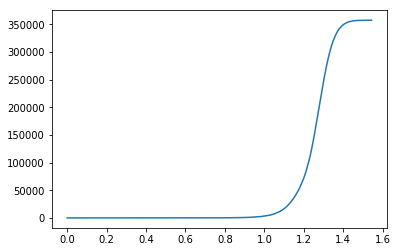

In [59]:
import matplotlib.pylab as plt
% matplotlib inline
s = 0
x, y =list(), list()
for i in keys:
    s += len(sim[i])
    x.append(i)
    y.append(s)
plt.plot(x, y)

### 2.2. SImilarity With Filtration

In [64]:
import pickle
def transform(phrase):
    def cond(word):
        _ = ['_NOUN', '_VERB','_ADV', '_ADJ']
        for i in _:
            if i in word:
                return True
        return False
    phrase = phrase.copy()
    for i in phrase:
        if not cond(i):
            phrase.remove(i)
    return phrase

with open('action_data.pickle', 'rb') as f: 
    phrases_transform = pickle.load(f)
new = list()
for i in phrases_transform:
    new.append(transform(i))

In [65]:
import time
t = time.time()
for i in range(D.shape[0]):
    for j in range(i+1, D.shape[1]):
        if D[i, j] != np.inf:
            D[i,j] = model.wmdistance(new[i], new[j])
            D[j, i] = D[i, j]
            if i == 0 and j == 100:
                print((time.time() - t)/100*D.shape[0]*D.shape[0] * 0.9 * 0.5)

894.8457384195327


#### Output

In [60]:
sim_filtr = dict()
for i in range(D.shape[0]):
    for j in range(i+1, D.shape[1]):
        if D[i,j] != np.inf and not np.isnan(D[i,j]):
            if not sim_filtr.__contains__(D[i,j]):
                sim_filtr[D[i,j]] = []
            sim_filtr[D[i,j]].append((i, j, phrases[i], phrases[j]))

In [61]:
keys = list(sim_filtr.keys())
keys.sort()

In [62]:
def print_eps(eps, keys, mydict):
    i = 0
    while keys[i] < eps and i < len(keys):
        if  keys[i] > 0:
            for item in mydict[keys[i]]:
                print(keys[i], item[0],':',item[2],'\t',item[1],':', item[3])
        i += 1

In [63]:
print_eps(1.0, keys, sim_filtr)

0.20382673936834655 412 : Также читайте : Как выбрать марку автомобиля  	 606 : Подробнее читайте , как выбрать марку автомобиля ; 
0.22344495100013712 412 : Также читайте : Как выбрать марку автомобиля  	 453 : Также читайте : Как выбрать автомобиль под себя 
0.22619180971547098 453 : Также читайте : Как выбрать автомобиль под себя  	 609 : Также читайте : Как выбрать автомобиль под свои потребности 
0.2319723895653806 412 : Также читайте : Как выбрать марку автомобиля  	 609 : Также читайте : Как выбрать автомобиль под свои потребности 
0.29917577929512224 418 : Также читайте : Какой пробег считается нормальным для б / у авто  	 615 : Также читайте : Какой пробег считается нормальным для подержанного автомобиля 
0.32565300043518336 10 : Это можно сделать на сайте ГИБДД или avtokod .  	 433 : Сделать это можно на сайте reestr - zalogov . 
0.4209312067353194 453 : Также читайте : Как выбрать автомобиль под себя  	 606 : Подробнее читайте , как выбрать марку автомобиля ; 
0.444167432008

#### Distance Distribution

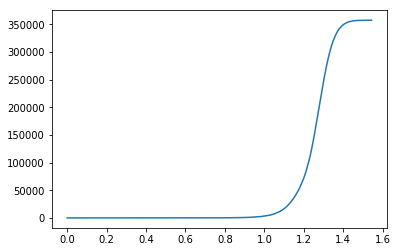

In [57]:
import matplotlib.pylab as plt
% matplotlib inline
s = 0
x, y =list(), list()
for i in keys:
    s += len(sim[i])
    x.append(i)
    y.append(s)
plt.plot(x, y)